# NER (Transformers)

## Установка пакетов и импорты

In [5]:
!pip install --break-system-packages datasets -q
#!pip install --break-system-packages tokenizers -q
#!pip install --break-system-packages transformers -q
#!pip install --break-system-packages transformers[torch] -q
!pip install --break-system-packages seqeval -q
!pip install --break-system-packages evaluate -q
#!pip install --break-system-packages wandb -q
#!pip install --break-system-packages tensorboard -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.2 MB/s eta 0:00:00


In [6]:
import numpy as np
import matplotlib.pyplot as plt

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification
from transformers import TrainingArguments, Trainer
import evaluate


import wandb
wandb.init(mode="disabled")

## Загрузка и обработка датасета

В качестве датсета для тренировки возьмём датасет WikiAnn (Pan-X). Возьмём русскую часть датасета.

In [7]:
dataset = load_dataset('wikiann', 'ru')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/158k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/809k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/816k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [8]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

Датасет состоит из трёх частей: тренировочной, валидационной и тестовой. Рассмотрим метки разметки NER.

In [9]:
dataset['train'].features['ner_tags'].feature.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

- O -- обозначает "Вне" и используется для указания токенов, которые не принадлежат никакой именованной сущности. Она применяется для обозначения слов, которые не являются частью имени человека, организации или места.
- B-PER -- обозначает "Начало Персоны". Используется для указания первого токена имени человека. Например, в имени "Джон Смит" "Джон" будет отмечен как B-PER.
- I-PER -- обозначает "Внутри Персоны". Относится к токенам, которые продолжают имя человека после начального токена. В "Джон Смит" "Смит" будет отмечен как I-PER.
- B-ORG -- обозначает "Начало Организации". Используется для идентификации первого токена названия организации, например, "Apple Inc." В этом случае "Apple" будет отмечен как B-ORG.
- I-ORG -- обозначает "Внутри Организации". Оно относится к токенам, которые являются частью названия организации, но не являются первым токеном. Например, в "Apple Inc." "Inc." будет отмечен как I-ORG.
- B-LOC -- обозначает "Начало Локации". Указывает на первый токен названия географического места, как "Нью-Йорк", где "Нью" будет отмечен как B-LOC.
- I-LOC -- обозначает "Внутри Локации". Относится к токенам, которые являются частью названия местоположения, но не являются первым токеном.

In [10]:
label_names= dataset['train'].features['ner_tags'].feature.names

В качестве первой модели используем модель RuBERT в чувствительном к регистру варианте. Чувствительность к регистру может улучшить распознавание сущности. Загрузим токенизатор.

In [11]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Размер словаря:

In [12]:
tokenizer.vocab_size

119547

Так как, разметка представлена для отдельных слов, а BERT использует BPE-токенизатор, который может разбивать слова на составные части, необходимо сопоставить токены - NER-разметки.

In [13]:
def tokenize_adjust_labels(all_samples_per_split):
    """Функция подготовки датасета и сопоставления токенов NER-разметки"""
    tokenized_samples = tokenizer.batch_encode_plus(all_samples_per_split["tokens"], is_split_into_words=True, max_length=512, truncation=True)

    total_adjusted_labels = []
    for k in range(0, len(tokenized_samples["input_ids"])):

        prev_wid = -1
        word_ids_list = tokenized_samples.word_ids(batch_index=k)
        existing_label_ids = all_samples_per_split["ner_tags"][k]
        i = -1
        adjusted_label_ids = []

        for wid in word_ids_list:
            if wid is None:
                adjusted_label_ids.append(-100) # -100 принято использовать для обозначение спец. токенов (CLS, PAD, SEP)
            elif wid != prev_wid:
                i = i + 1
                adjusted_label_ids.append(existing_label_ids[i])
                prev_wid = wid
            else:
                label_name = label_names[existing_label_ids[i]]
                adjusted_label_ids.append(existing_label_ids[i])

        total_adjusted_labels.append(adjusted_label_ids)
    tokenized_samples["labels"] = total_adjusted_labels
    return tokenized_samples

Применяем функцию к датасету и удаляем лишине столбцы.

In [14]:
tokenized_dataset = dataset.map(tokenize_adjust_labels, batched=True, remove_columns=['tokens', 'ner_tags', 'langs', 'spans'])
tokenized_dataset

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

DatasetDict({
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 20000
    })
})

Проверяем:

In [15]:
dataset['train'][0:2]

{'tokens': [['Илизаров', ',', 'Гавриил', 'Абрамович'],
  ["'", "''", 'Рыбницкий', 'район', "''", "'"]],
 'ner_tags': [[1, 2, 2, 2], [0, 0, 5, 6, 0, 0]],
 'langs': [['ru', 'ru', 'ru', 'ru'], ['ru', 'ru', 'ru', 'ru', 'ru', 'ru']],
 'spans': [['PER: Илизаров , Гавриил Абрамович'], ['LOC: Рыбницкий район']]}

In [16]:
tokenized_dataset['train'][0:2]

{'input_ids': [[101, 35377, 31332, 1388, 128, 56031, 41439, 102],
  [101, 118, 118, 118, 21919, 30310, 5679, 118, 118, 118, 102]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'labels': [[-100, 1, 1, 1, 2, 2, 2, -100],
  [-100, 0, 0, 0, 5, 5, 6, 0, 0, 0, -100]]}

## Finetunning модели

Создадим объект класса, для подготовки данных для задач классификации токенов.

In [17]:
data_collator = DataCollatorForTokenClassification(tokenizer)

Загрузим модель для классификации токенов.

In [18]:
model = AutoModelForTokenClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=len(label_names))

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
print(model)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [20]:
num_params = sum(p.numel() for p in model.parameters())
print(f'Общее количество параметров модели BERT: {num_params}')

Общее количество параметров модели BERT: 177268231


Для оценивания метрик будем использовать Seqeval - фреймворк для оценки в задачах классификации токенов.

In [21]:
metric = evaluate.load("seqeval")

Функция расчёта метрик.

In [22]:
def compute_metrics(p):
    predictions, labels = p
    #select predicted index with maximum logit for each token
    predictions = np.argmax(predictions, axis=2)
    # Remove ignored index (special tokens)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

Настройки обучения.

In [23]:
batch_size = 100
logging_steps = 50
learning_rate = 1e-4
epochs = 2

In [24]:
args = TrainingArguments(report_to=None,
                         output_dir="./results",
                         num_train_epochs=epochs,
                         learning_rate = learning_rate,
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=batch_size,
                         eval_strategy="steps",
                         disable_tqdm=False,
                         logging_steps=logging_steps)

In [25]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-25-98d10d45469b>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Запускаем обучение.

In [26]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
50,0.484100,0.207072,0.858404,0.852578,0.855481,0.938557
100,0.234500,0.196592,0.877472,0.876190,0.876831,0.945283
150,0.187700,0.171138,0.888168,0.890847,0.889506,0.950528
200,0.169900,0.157640,0.897608,0.894901,0.896252,0.954822
250,0.115200,0.154205,0.885031,0.910642,0.897654,0.955594
300,0.106100,0.157218,0.897076,0.912339,0.904643,0.957582
350,0.100500,0.141389,0.900486,0.916486,0.908416,0.958640
400,0.092300,0.140482,0.906190,0.916910,0.911519,0.960533


TrainOutput(global_step=400, training_loss=0.18629176855087282, metrics={'train_runtime': 448.1757, 'train_samples_per_second': 89.251, 'train_steps_per_second': 0.893, 'total_flos': 775300481491800.0, 'train_loss': 0.18629176855087282, 'epoch': 2.0})

Обучение успешно, метрики хорошие, правда наблюдается небольшое переобучение, но не критично. Замеряем метрики на тестовом.

In [27]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)

true_predictions = [[label_names[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
true_labels = [[label_names[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'LOC': {'precision': 0.9027359437751004,
  'recall': 0.917591529531828,
  'f1': 0.9101031188713861,
  'number': 7839},
 'ORG': {'precision': 0.83125,
  'recall': 0.8384071340713407,
  'f1': 0.8348132271892225,
  'number': 6504},
 'PER': {'precision': 0.9499170312264293,
  'recall': 0.9644662275999387,
  'f1': 0.9571363429092568,
  'number': 6529},
 'overall_precision': 0.8953537836177152,
 'overall_recall': 0.9075795323878881,
 'overall_f1': 0.9014252064051014,
 'overall_accuracy': 0.9567397595144322}

Примерно те же.

## Инференс

In [28]:
text = "Я, Иванов Иван Иванович, родился. в городе Москве. В 1987 г. поступил в среднюю школу и в 1997 г. её окончил. После окончания школы в 1997 г. поступил на факультет вычислительной математики и кибернетики Московского университета"
tokens = tokenizer(text, return_tensors="pt")

In [29]:
tokens = {k:v.to(device) for k, v in tokens.items()}
with torch.no_grad():
       outputs = model(**tokens)
       predictions = torch.argmax(outputs.logits, dim=2)

In [30]:
label_map = {0: "O", 1: "B-PER", 2: "I-PER", 3: "B-ORG", 4: "I-ORG", 5: "B-LOC", 6: "I-LOC"}
predicted_labels = [label_map[label.item()] for label in predictions[0]]

# Работа с токенами и метками
word_labels = []
for token, label in zip(tokenizer.convert_ids_to_tokens(tokens["input_ids"][0]), predicted_labels):
    if token.startswith("##"):
        word_labels[-1] += f" {token[2:]}"  # Сливаем с предыдущим словом
    else:
        word_labels.append(f"{token}|{label}")

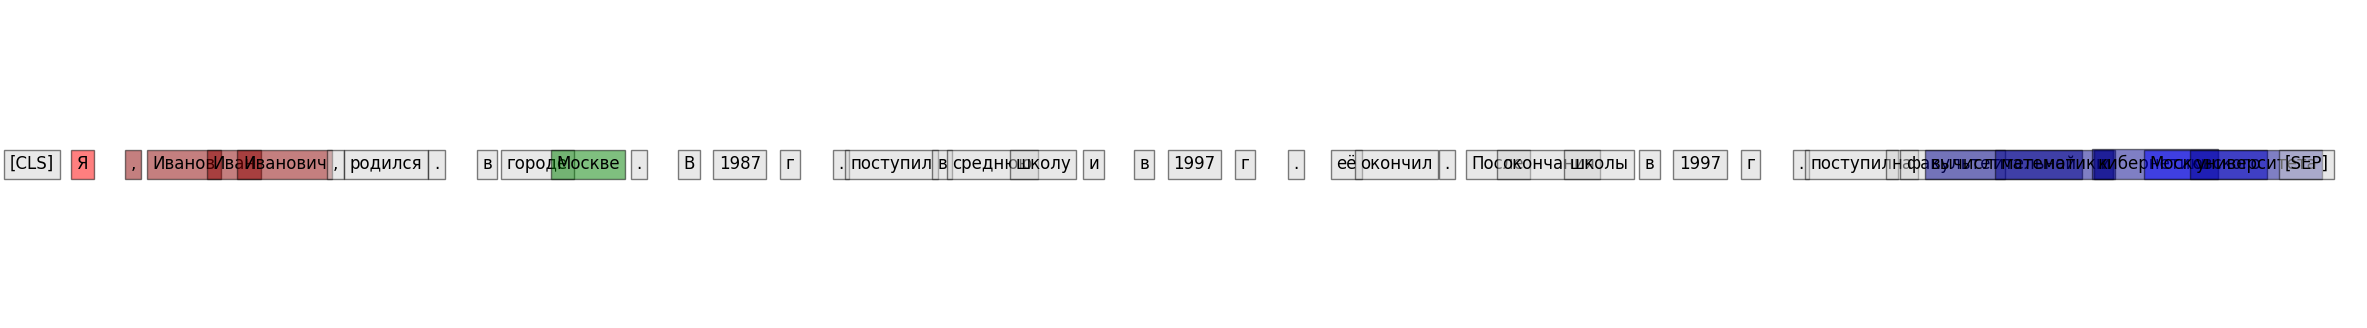

In [31]:
colors = {
    "B-PER": "red",
    "I-PER": "darkred",
    "B-ORG": "blue",
    "I-ORG": "darkblue",
    "B-LOC": "green",
    "I-LOC": "darkgreen",
    "O": "lightgrey"
} # цвета меток

fig, ax = plt.subplots(figsize=(30, 4))
ax.set_xlim(0, len(word_labels) * 0.5)
ax.set_ylim(0, 1)

   # Добавление текстов с выделением
for i, word_label in enumerate(word_labels):
    word, label = word_label.split("|")
    ax.text(i * 0.5, 0.5, word, fontsize=12, ha='center', va='center',
            bbox=dict(facecolor=colors.get(label, "lightgrey"), alpha=0.5))

ax.axis('off')
plt.show()

## Улучшение качества или производительности

Качество по метрикам и так хорошее, попробуем взять и настроить уменьшенную модель.

In [32]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/distilrubert-tiny-cased-conversational-v1")

tokenizer_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/175 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/382k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Размер словаря:

In [33]:
tokenizer.vocab_size

30522

In [34]:
tokenized_dataset = dataset.map(tokenize_adjust_labels, batched=True, remove_columns=['tokens', 'ner_tags', 'langs', 'spans'])
tokenized_dataset

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

DatasetDict({
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 20000
    })
})

In [35]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [36]:
model = AutoModelForTokenClassification.from_pretrained("DeepPavlov/distilrubert-tiny-cased-conversational-v1", num_labels=len(label_names))

pytorch_model.bin:   0%|          | 0.00/41.6M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
print(model)

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 264, padding_idx=0)
      (position_embeddings): Embedding(512, 264)
      (LayerNorm): LayerNorm((264,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-2): 3 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=264, out_features=264, bias=True)
            (k_lin): Linear(in_features=264, out_features=264, bias=True)
            (v_lin): Linear(in_features=264, out_features=264, bias=True)
            (out_lin): Linear(in_features=264, out_features=264, bias=True)
          )
          (sa_layer_norm): LayerNorm((264,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
   

In [38]:
num_params = sum(p.numel() for p in model.parameters())
print(f'Общее количество параметров модели BERT: {num_params}')

Общее количество параметров модели BERT: 10295743


In [39]:
batch_size = 400 # можно увеличить размер батча
logging_steps = 25
learning_rate = 1e-3
epochs = 3
optim = "adamw_torch" # На больших батчах возрастает вероятность переобучения введём регуляризацию
wd = 0.01

In [40]:
args = TrainingArguments(report_to=None,
                         output_dir="./results",
                         num_train_epochs=epochs,
                         learning_rate = learning_rate,
                         optim = optim,
                         weight_decay = wd,
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=batch_size,
                         eval_strategy="steps",
                         disable_tqdm=False,
                         logging_steps=logging_steps)

In [41]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-41-98d10d45469b>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Запускаем обучение.

In [42]:
trainer.train()

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
25,1.043300,0.485225,0.649401,0.696795,0.672263,0.832972
50,0.409900,0.328888,0.785720,0.795412,0.790537,0.894400
75,0.278200,0.299049,0.805235,0.828284,0.816597,0.906676
100,0.253700,0.277478,0.819174,0.833646,0.826346,0.912959
125,0.182600,0.268544,0.830284,0.844369,0.837267,0.917578
150,0.170000,0.266137,0.834100,0.849936,0.841943,0.919180


TrainOutput(global_step=150, training_loss=0.38960625012715655, metrics={'train_runtime': 64.1375, 'train_samples_per_second': 935.49, 'train_steps_per_second': 2.339, 'total_flos': 44531558419200.0, 'train_loss': 0.38960625012715655, 'epoch': 3.0})

Обучение успешно, метрики хуже, чем у большой модели, но соотношение цена(число параметров, скорость обучения и инференса)/качество по метрикам выше.

In [43]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)

true_predictions = [[label_names[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
true_labels = [[label_names[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'LOC': {'precision': 0.8445740956826138,
  'recall': 0.8513958594730239,
  'f1': 0.8479712578591793,
  'number': 12752},
 'ORG': {'precision': 0.739230632866513,
  'recall': 0.7603938730853391,
  'f1': 0.7496629213483146,
  'number': 10968},
 'PER': {'precision': 0.9032846715328468,
  'recall': 0.9257142857142857,
  'f1': 0.9143619477654061,
  'number': 9625},
 'overall_precision': 0.8266521572894915,
 'overall_recall': 0.8429149797570851,
 'overall_f1': 0.8347043625456598,
 'overall_accuracy': 0.9185682709669385}